title: First feature explorations and a simple Logistic Regression Model  
author: Jesse Scherwitz  
date: 2021-02-01  
region: EU  
summary: Model to predict the customers that are likely to be written-off. Plan is use this knowledge to take specific actions to turn them into recovery. With this first Model Version we would be able to predict write offs with 78% accuracy.
link: https://docs.google.com/presentation/d/1jsdJ-kPyxB9rRSRMZPTjufJ_fr5HvQZ1MGXGCoTgRmk/edit#slide=id.gb9d2a1ff7a_0_0  
tags: operations, dunning, write off, prediction, logistic regression

In [ ]:
"""This contains first feature explorations and a simple Logistic Regression Model to predict write-offs."""

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML
from pathlib import Path
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score,
    classification_report,
)  # , confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import (
    train_test_split,
)  # , GridSearchCV, RandomizedSearchCV

In [90]:
HTML(
    """<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>"""
)

In [139]:
# data = pd.read_csv("fra/live/write_off_pred.csv")

data = pd.read_csv(
    "/app/research/operations/dunning/write_off_predictions/data/exploration_write_off_pred.csv"
)

In [140]:
data["arrears_amount_eur"] = data["arrears_amount_cents"] / 100
data.drop(columns=["arrears_amount_cents"], inplace=True)

In [141]:
features = [
    "current_status",
    "tnc_country_group",
    "age_group",
    "initial_arrears_reason",
    "days_in_dunning",
    "arrears_amount_eur",
    "days_since_kycc",
    "cnt_times_arrears",
    "lifetime_txn_count",
    "logins",
    "arrears_start_tstmp",
    "arrears_end_tstmp",
]

In [142]:
data = data[features]

### Only the most recent case, only recovered / written off!

# First Analysis

In [144]:
len(data)

276432

<AxesSubplot:>

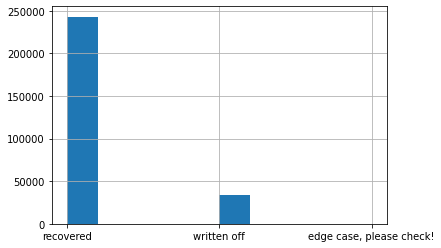

In [145]:
data.current_status.hist()

In [146]:
data["arrears_start_month"] = data["arrears_start_tstmp"].astype(str).str[:7]
data["arrears_end_month"] = data["arrears_end_tstmp"].astype(str).str[:7]

In [147]:
y = data.groupby(["arrears_start_month"]).size()
z = data[data["current_status"] == "written off"].groupby(["arrears_end_month"]).size()

<AxesSubplot:xlabel='arrears_start_month'>

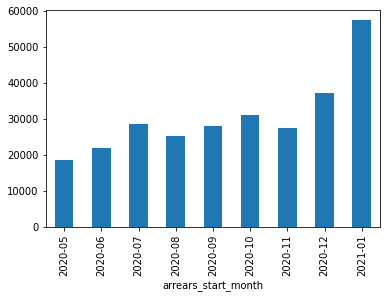

In [148]:
y.plot(kind="bar")

<AxesSubplot:xlabel='arrears_end_month'>

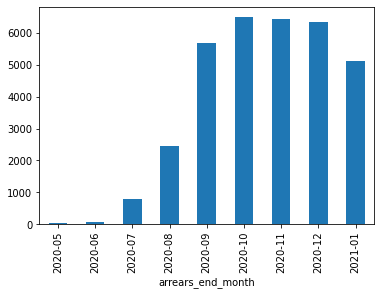

In [149]:
z.plot(kind="bar")

In [151]:
data.drop(
    columns=[
        "arrears_start_month",
        "arrears_end_month",
        "arrears_start_tstmp",
        "arrears_end_tstmp",
    ],
    inplace=True,
)

## Days in dunning

<AxesSubplot:>

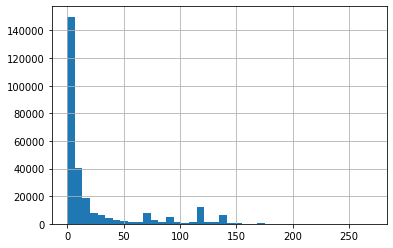

In [98]:
data.days_in_dunning.hist(bins=40)

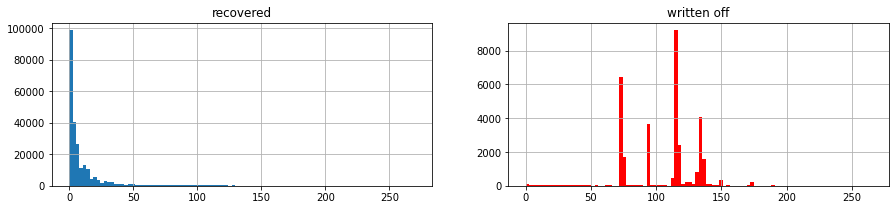

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))

data[data["current_status"] == "recovered"].days_in_dunning.hist(bins=100, ax=axes[0])
data[data["current_status"] == "written off"].days_in_dunning.hist(
    bins=100, ax=axes[1], color="r"
)
axes[0].set_title("recovered")
axes[1].set_title("written off")
plt.show()

In [33]:
# written off after few days in dunning?
data[data["current_status"] == "written off"].groupby(["days_in_dunning"]).size()

days_in_dunning
0      37
1      32
2      19
3      19
4      29
       ..
240     1
246     3
253     1
262     1
265     1
Length: 204, dtype: int64

## Idea: Throw away days_in_dunning ≤ 14

In [133]:
data14 = data[data["days_in_dunning"] > 14]

In [128]:
len(data14)

81531

<AxesSubplot:>

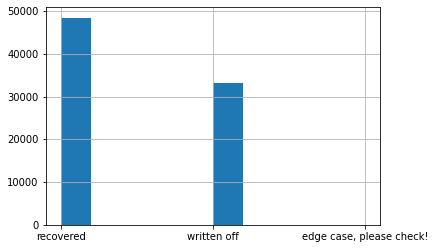

In [102]:
data14.current_status.hist()

## Days since KYCC

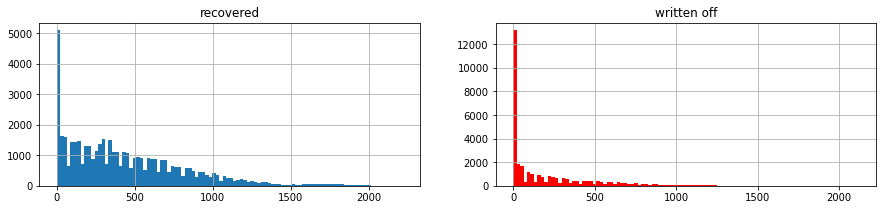

rec. mean =  453.8953822017629 				wr. mean =  222.5584839509158
rec. median =  366.0 					wr. median =  62.0


In [104]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))

data14[data14["current_status"] == "recovered"].days_since_kycc.hist(
    bins=100, ax=axes[0]
)
data14[data14["current_status"] == "written off"].days_since_kycc.hist(
    bins=100, ax=axes[1], color="r"
)
axes[0].set_title("recovered")
axes[1].set_title("written off")
plt.show()

print(
    "rec. mean = ",
    data14[data14["current_status"] == "recovered"].days_since_kycc.mean(),
    4 * "\t" + "wr. mean = ",
    data14[data14["current_status"] == "written off"].days_since_kycc.mean(),
)
print(
    "rec. median = ",
    data14[data14["current_status"] == "recovered"].days_since_kycc.median(),
    5 * "\t" + "wr. median = ",
    data14[data14["current_status"] == "written off"].days_since_kycc.median(),
)

 ## Numerical features: min/max/percentiles/...

In [132]:
features = [
    "current_status",
    "tnc_country_group",
    "age_group",
    "initial_arrears_reason",
    "arrears_amount_eur",
    #'days_in_dunning',
    "days_since_kycc",
    "cnt_times_arrears",
    "lifetime_txn_count",
    "logins",
]

In [134]:
data14_slim = data14[features].reset_index(drop=True)

In [46]:
data14_slim.describe()

,arrears_amount_eur,days_since_kycc,cnt_times_arrears,lifetime_txn_count,logins
count,81531.000000,81531.00000,81531.000000,81531.000000,81531.000000
mean,69.528385,360.01018,3.787136,213.018165,9.200145
std,469.671380,376.97417,4.580448,385.133759,16.666885
min,0.010000,0.00000,1.000000,0.000000,0.000000
25%,7.970000,31.00000,1.000000,5.000000,2.000000
50%,23.050000,245.00000,2.000000,67.000000,5.000000
75%,40.700000,566.00000,5.000000,252.000000,11.000000
max,29181.490000,2215.00000,68.000000,9780.000000,930.000000


## Recovered:

In [165]:
data14_slim[data14_slim["current_status"] == "recovered"].describe()

,arrears_amount_eur,days_since_kycc,cnt_times_arrears,lifetime_txn_count,logins
count,48443.000000,48443.000000,48443.000000,48443.000000,48443.000000
mean,34.782651,453.895382,4.371756,285.828210,10.308631
std,324.146470,390.559269,4.940708,429.491707,16.988444
min,0.010000,0.000000,1.000000,0.000000,0.000000
25%,3.990000,140.000000,1.000000,38.000000,2.000000
50%,9.840000,366.000000,3.000000,136.000000,6.000000
75%,23.200000,670.000000,6.000000,354.000000,12.000000
max,29181.490000,2215.000000,68.000000,9780.000000,930.000000


## Written off:

In [166]:
data14_slim[data14_slim["current_status"] == "written off"].describe()

,arrears_amount_eur,days_since_kycc,cnt_times_arrears,lifetime_txn_count,logins
count,33086.000000,33086.000000,33086.000000,33086.000000,33086.000000
mean,120.396899,222.558484,2.931149,106.423502,7.577465
std,620.802334,308.308192,3.837579,276.236941,16.047738
min,0.010000,0.000000,1.000000,0.000000,0.000000
25%,25.250000,15.000000,1.000000,0.000000,0.000000
50%,39.720000,62.000000,1.000000,5.000000,3.000000
75%,51.260000,332.000000,3.000000,80.000000,9.000000
max,28728.420000,2122.000000,59.000000,6244.000000,535.000000


## Cannot use days_in_dunning as feature!

## Remove outliers!

In [135]:
numeric_df = data14_slim[
    [
        "arrears_amount_eur",
        "days_since_kycc",
        "cnt_times_arrears",
        "lifetime_txn_count",
        "logins",
    ]
]

In [136]:
filtered_entries = (np.abs(stats.zscore(numeric_df)) < 3).all(axis=1)
data14_slim = data14_slim[filtered_entries].reset_index(drop=True)

In [137]:
data14 = data14_slim

## Lifetime txn's

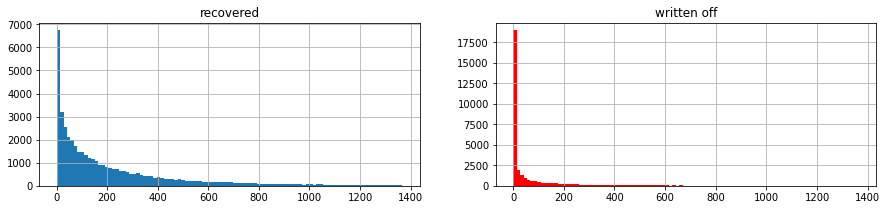

rec. mean =  217.38052479971194 			wr. mean =  76.08756801476437
rec. median =  120.0 					wr. median =  4.0


In [138]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))

data14[data14["current_status"] == "recovered"].lifetime_txn_count.hist(
    bins=100, ax=axes[0]
)
data14[data14["current_status"] == "written off"].lifetime_txn_count.hist(
    bins=100, ax=axes[1], color="r"
)
axes[0].set_title("recovered")
axes[1].set_title("written off")
plt.show()

print(
    "rec. mean = ",
    data14[data14["current_status"] == "recovered"].lifetime_txn_count.mean(),
    3 * "\t" + "wr. mean = ",
    data14[data14["current_status"] == "written off"].lifetime_txn_count.mean(),
)
print(
    "rec. median = ",
    data14[data14["current_status"] == "recovered"].lifetime_txn_count.median(),
    5 * "\t" + "wr. median = ",
    data14[data14["current_status"] == "written off"].lifetime_txn_count.median(),
)

## Enter reasons

<AxesSubplot:xlabel='initial_arrears_reason'>

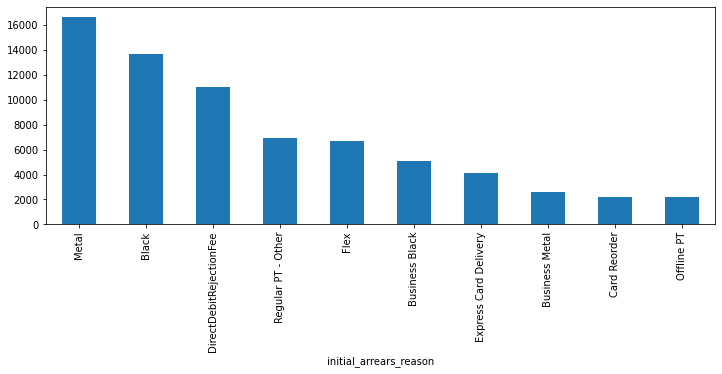

In [23]:
data14.groupby(["initial_arrears_reason"]).size().sort_values(ascending=False)[
    :10
].plot(kind="bar", figsize=(12, 4))

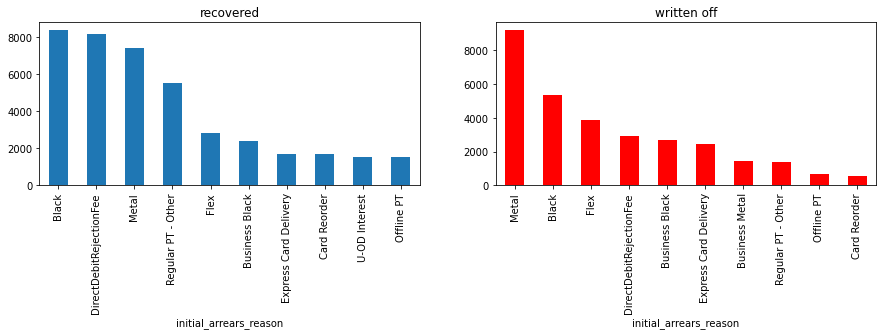

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))

data14[data14["current_status"] == "recovered"].groupby(
    ["initial_arrears_reason"]
).size().sort_values(ascending=False)[:10].plot(
    kind="bar",
    ax=axes[0],
)
data14[data14["current_status"] == "written off"].groupby(
    ["initial_arrears_reason"]
).size().sort_values(ascending=False)[:10].plot(kind="bar", ax=axes[1], color="r")
axes[0].set_title("recovered")
axes[1].set_title("written off")
plt.show()

## Times in Arrears

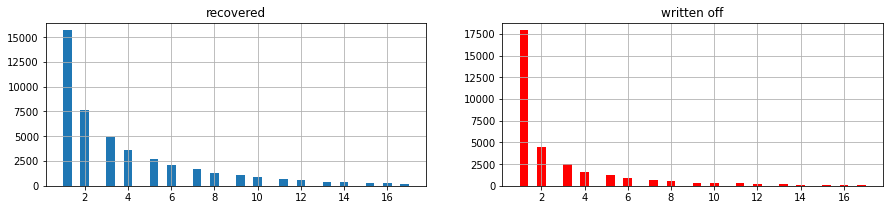

rec. mean =  3.7023809523809526 			wr. mean =  2.5731695675692876
rec. median =  2.0 					wr. median =  1.0


In [34]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))

data14[data14["current_status"] == "recovered"].cnt_times_arrears.hist(
    bins=40, ax=axes[0]
)
data14[data14["current_status"] == "written off"].cnt_times_arrears.hist(
    bins=40, ax=axes[1], color="r"
)
axes[0].set_title("recovered")
axes[1].set_title("written off")
plt.show()

print(
    "rec. mean = ",
    data14[data14["current_status"] == "recovered"].cnt_times_arrears.mean(),
    3 * "\t" + "wr. mean = ",
    data14[data14["current_status"] == "written off"].cnt_times_arrears.mean(),
)
print(
    "rec. median = ",
    data14[data14["current_status"] == "recovered"].cnt_times_arrears.median(),
    5 * "\t" + "wr. median = ",
    data14[data14["current_status"] == "written off"].cnt_times_arrears.median(),
)

## Arrears Amt €

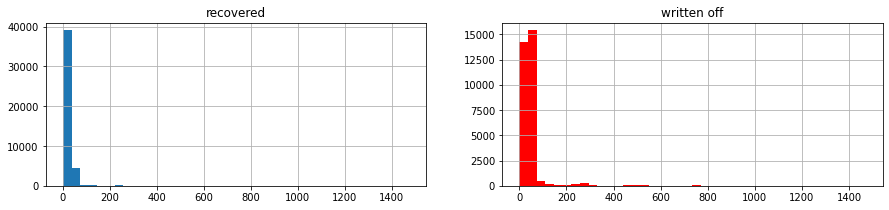

rec. mean =  19.383282923755516 			wr. mean =  53.69744550863906
rec. median =  9.8 					wr. median =  39.48


In [28]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))

(data14[data14["current_status"] == "recovered"].arrears_amount_eur).hist(
    bins=40, ax=axes[0]
)
(data14[data14["current_status"] == "written off"].arrears_amount_eur).hist(
    bins=40, ax=axes[1], color="r"
)
axes[0].set_title("recovered")
axes[1].set_title("written off")
plt.show()

print(
    "rec. mean = ",
    data14[data14["current_status"] == "recovered"].arrears_amount_eur.mean(),
    3 * "\t" + "wr. mean = ",
    data14[data14["current_status"] == "written off"].arrears_amount_eur.mean(),
)
print(
    "rec. median = ",
    data14[data14["current_status"] == "recovered"].arrears_amount_eur.median(),
    5 * "\t" + "wr. median = ",
    data14[data14["current_status"] == "written off"].arrears_amount_eur.median(),
)

## Logins

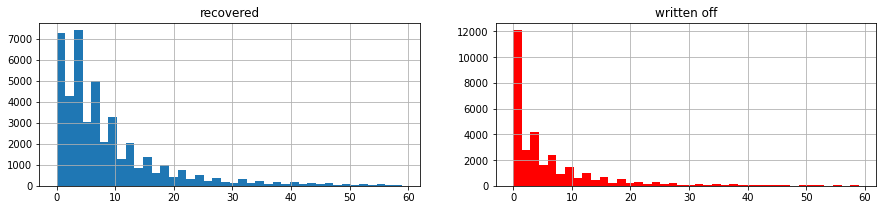

rec. mean =  8.736970024304618 				wr. mean =  6.189709485474274
rec. median =  6.0 					wr. median =  3.0


In [30]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))

data14[data14["current_status"] == "recovered"].logins.hist(bins=40, ax=axes[0])
data14[data14["current_status"] == "written off"].logins.hist(
    bins=40, ax=axes[1], color="r"
)
axes[0].set_title("recovered")
axes[1].set_title("written off")
plt.show()

print(
    "rec. mean = ",
    data14[data14["current_status"] == "recovered"].logins.mean(),
    4 * "\t" + "wr. mean = ",
    data14[data14["current_status"] == "written off"].logins.mean(),
)
print(
    "rec. median = ",
    data14[data14["current_status"] == "recovered"].logins.median(),
    5 * "\t" + "wr. median = ",
    data14[data14["current_status"] == "written off"].logins.median(),
)

In [39]:
data14[data14["current_status"] == "written off"].groupby(["logins"]).size()[:10]
# data14[data14["current_status"]=="recovered"].groupby(["logins"]).size()

logins
0    8516
1    3553
2    2777
3    2274
4    1873
5    1639
6    1310
7    1105
8     937
9     786
dtype: int64

## TNC Country Group

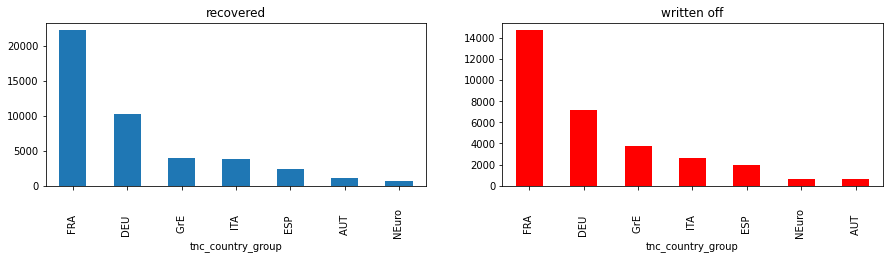

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))

data14[data14["current_status"] == "recovered"].groupby(
    ["tnc_country_group"]
).size().sort_values(ascending=False)[:10].plot(
    kind="bar",
    ax=axes[0],
)
data14[data14["current_status"] == "written off"].groupby(
    ["tnc_country_group"]
).size().sort_values(ascending=False)[:10].plot(kind="bar", ax=axes[1], color="r")
axes[0].set_title("recovered")
axes[1].set_title("written off")
plt.show()

<AxesSubplot:xlabel='tnc_country_group'>

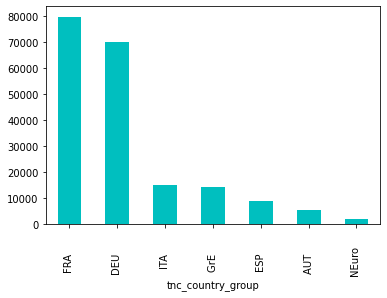

In [53]:
## out of interest: looking at customers who recovered in the first 14 days.

data[data["days_in_dunning"] <= 14].groupby(["tnc_country_group"]).size().sort_values(
    ascending=False
)[:10].plot(kind="bar", color="c")

## Age Group

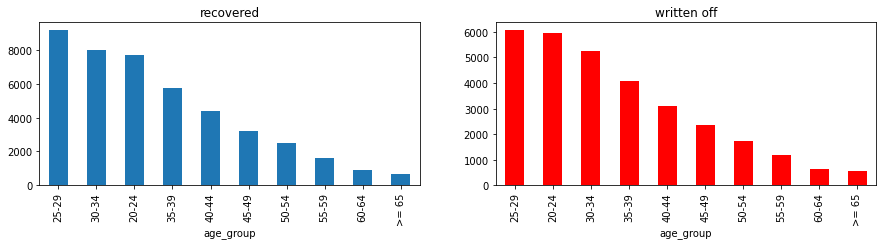

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))

data14[data14["current_status"] == "recovered"].groupby(
    ["age_group"]
).size().sort_values(ascending=False)[:10].plot(
    kind="bar",
    ax=axes[0],
)
data14[data14["current_status"] == "written off"].groupby(
    ["age_group"]
).size().sort_values(ascending=False)[:10].plot(kind="bar", ax=axes[1], color="r")
axes[0].set_title("recovered")
axes[1].set_title("written off")
plt.show()

# Prediction Algo

In [65]:
data14_algo = data14

In [66]:
for col_name in data14_algo.columns:
    if data14_algo[col_name].dtype == "object":
        data14_algo[col_name] = data14_algo[col_name].astype("category")
        data14_algo[col_name] = data14_algo[col_name].cat.codes

In [67]:
data14_algo

,current_status,tnc_country_group,age_group,initial_arrears_reason,arrears_amount_eur,days_since_kycc,cnt_times_arrears,lifetime_txn_count,logins
0,1,1,5,28,2.17,1345,6,67,2
1,1,1,3,28,15.49,1292,11,241,1
2,1,1,3,21,283.82,990,4,220,11
3,1,3,4,1,4.99,1131,5,221,2
4,1,1,4,9,201.52,1479,11,316,2
...,...,...,...,...,...,...,...,...,...
75860,2,3,4,18,51.66,15,1,0,3
75861,1,3,3,3,60.53,15,1,0,7
75862,2,3,3,18,51.51,15,1,0,2
75863,2,1,3,15,24.20,10,1,0,0


In [68]:
# Split into features and labels.
X = data14_algo.drop("current_status", axis=1)
Y = data14_algo["current_status"]

In [69]:
# Split into train and test sets.
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

In [70]:
logmodel = LogisticRegression(max_iter=10000)
logmodel.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Results

In [71]:
predictions = logmodel.predict(X_test)

In [76]:
predictions

array([1, 1, 2, ..., 2, 1, 1], dtype=int8)

In [74]:
print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           1       0.81      0.85      0.83      8864
           2       0.78      0.73      0.75      6309

    accuracy                           0.80     15173
   macro avg       0.79      0.79      0.79     15173
weighted avg       0.80      0.80      0.80     15173

